# Load images

In [1]:
import os
import numpy as np
from PIL import Image # OpenCV does not support opening GIFs

# Get image filenames
filenames = [fn for fn in os.listdir("images") if os.path.isfile(f"images/{fn}")]

# Creates a list of dict in the format of ...
# [{'filename': <file name of image>, 'image': <numpy array of pixel values>}, ...]
images = []
for filename in filenames:
    image_path = f"images/{filename}"
    with Image.open(image_path) as img:
        img = np.array(img, dtype=bool)
    images.append({'filename': filename, 'image': img})

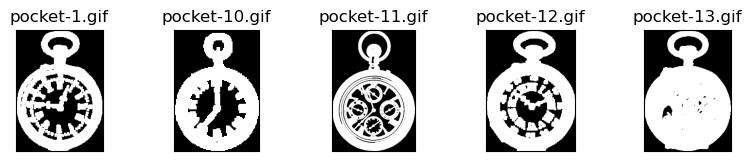

In [2]:
from utils import image_show

imgs = [img['image'] for img in images[340:345]]
fns = [img['filename'] for img in images[340:345]]
image_show(imgs, fns)

# Pre-processing

In [3]:
import cv2
from torchvision import transforms
from torchvision.transforms.functional import gaussian_blur

for index, image in enumerate(images):
    image = image['image']
    image = image.astype(np.uint8) # Convert to grayscale
    
    # Morphologically open image
    kernel = np.ones((5, 5), np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=1)
    
    image = image.astype(bool) # Convert to binary
    image = Image.fromarray(image) # Convert to PIL object
    
    # Resize to 224 x 224
    image = image.resize((224, 224), resample=Image.Resampling.LANCZOS)
    
    # Convert to RGB for input into CNN
    image = image.convert('RGB')
    
    # Add gaussian blur
    image = gaussian_blur(image, (13, 13))
    
    image = np.array(image) # Convert back to numpy array
    images[index]['image'] = image

# Convert to tensor and normalize according to mean and standard deviation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.8, 0.9, 0.9), (0.58, 0.5, 0.5))
])

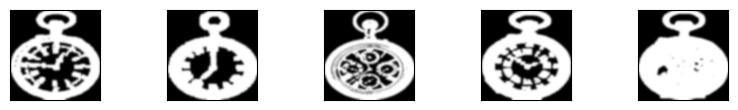

In [4]:
imgs = [im['image'] for im in images[340:345]]
image_show(imgs)

# Feature extraction

In [5]:
import torch
from torchvision.models import mobilenet_v3_small

model = mobilenet_v3_small(weights="DEFAULT")
model.classifier = torch.nn.Identity() # model.classifier[:1] # torch.nn.Identity()
model.eval()
model = torch.jit.script(model) # JIT optimize model
model = torch.jit.optimize_for_inference(model) # Fuse batch norm + cnn layers

In [6]:
from tqdm.auto import tqdm

features = {}
with torch.inference_mode():
    for img in tqdm(images):
        filename = img['filename']
        image = img['image']
        
        # Tensorize, normalize, and add batch dimension
        image = transform(image)
        image = image.unsqueeze(0)
        
        # Extract features
        feature = model(image)
        
        # Remove batch dimension and convert features to numpy array
        feature = feature.squeeze(0)
        feature = feature.detach().cpu().numpy()
        
        features.update({filename: feature})

  0%|          | 0/400 [00:00<?, ?it/s]

# Save features

In [7]:
import pickle

with open("features.pickle", 'wb') as file:
    pickle.dump(features, file)

# Average precision and recall

In [8]:
precisions = []
recalls = []
tps, fps, fns, tns = [], [], [], []

for filename, feature in features.items():
    # Calculate Euclidean difference between input feature and features in database
    dist_index = []
    for filename_db, feature_db in features.items():
        dist = np.linalg.norm(feature-feature_db)
        dist_index.append({'filename': filename_db, 'distance': dist})

    # Sort by distance in ascending order
    dist_index = sorted(dist_index, key = lambda x: x['distance'])

    # Obtain class string from input feature
    img_class = filename.split('-')[0]

    # Obtain class string from retrieved images' filename
    ret_classes = [dist['filename'].split('-')[0] for dist in dist_index[:20]]

    # Number of images that should be retrieved and was
    tp = sum([img_class == ret_class for ret_class in ret_classes])

    # Number of images that shouldn't be retrieved but was
    fp = len(ret_classes) - tp

    # Number of images that should be retrieved but wasn't
    fn = sum([True for fn in features.keys() if img_class in fn]) - tp

    # Number of images that shouldn't be retrieved and wasn't
    tn = sum([True for fn in features.keys() if img_class not in fn]) - fp

    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)
    # precisions.append(tp / (tp + fp))
    # recalls.append(tp / (tp + fn))

tps, fps, fns, tns = sum(tps), sum(fps), sum(fns), sum(tns)
precision = tps / (tps + fps)
recall = tps / (tps + fns)

print(f"TP: {tps}\tFP: {fps}\nFN: {fns}\tTN: {tns}")
print(f"Average precision (micro): {precision:.3f}")
print(f"Average recall (micro): {recall:.3f}")
# print(f"Average precision (macro): {sum(precisions)/len(precisions):.3f}")
# print(f"Average recall (macro): {sum(recalls)/len(recalls):.3f}")

TP: 6446	FP: 1554
FN: 1554	TN: 150446
Average precision (micro): 0.806
Average recall (micro): 0.806
